Let us dig into tensors.

Some of the examples are from [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). 

## Data representations for neural networks

### Scalars (rank-0 tensors)

In [1]:
import numpy as np
x = np.array(12)
x

array(12)

In [2]:
x.ndim

0

### Vectors (rank-1 tensors)

In [3]:
x = np.array([12, 3, 6, 14, 7])
x

array([12,  3,  6, 14,  7])

In [4]:
x.ndim

1

### Matrices (rank-2 tensors)

In [5]:
x = np.array([[5, 78, 2, 34, 0],
              [6, 79, 3, 35, 1],
              [7, 80, 4, 36, 2]])
x.ndim

2

### Rank-3 and higher-rank tensors

In [6]:
x = np.array([[[5, 78, 2, 34, 0],
               [6, 79, 3, 35, 1],
               [7, 80, 4, 36, 2]],
              [[5, 78, 2, 34, 0],
               [6, 79, 3, 35, 1],
               [7, 80, 4, 36, 2]],
              [[5, 78, 2, 34, 0],
               [6, 79, 3, 35, 1],
               [7, 80, 4, 36, 2]]])
x.ndim

3

### Key attributes

So every tensor has: Number of axis (rank), Shape, Data type

In [7]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [8]:
train_images.ndim

3

In [9]:
train_images.shape

(60000, 28, 28)

In [10]:
train_images.dtype

dtype('uint8')

**Displaying the fourth digit**

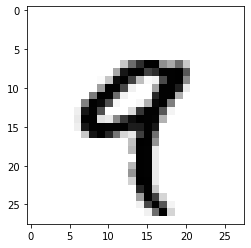

In [8]:
import matplotlib.pyplot as plt
digit = train_images[4]
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

In [12]:
train_labels[4]

9

### Manipulating tensors in NumPy

In [9]:
my_slice = train_images[10:100]
my_slice.shape

(90, 28, 28)

In [14]:
my_slice = train_images[10:100, :, :]
my_slice.shape

(90, 28, 28)

In [15]:
my_slice = train_images[10:100, 0:28, 0:28]
my_slice.shape

(90, 28, 28)

In [13]:
my_slice = train_images[:, 14:, 14:]

In [10]:
my_slice = train_images[:, 7:-7, 7:-7]
my_slice.shape

(60000, 14, 14)

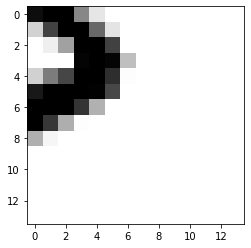

In [14]:
digit = my_slice[0]
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

### The notion of data batches

The first axis: samples axis (our data points)

In [15]:
batch = train_images[:128]

In [16]:
batch = train_images[128:256]

In [17]:
n = 3
batch = train_images[128 * n:128 * (n + 1)]


<img src="../img/tensor-samples.png" alt="Samples" style="width:300px;"/>

Source: https://www.manning.com/books/deep-learning-with-python  

## The gears of neural networks: tensor operations

### Element-wise operations

<img src="../img/relu.png" alt="Relu Activation" style="width:600px;"/>

In [18]:
def naive_relu(x):
    assert len(x.shape) == 2
    x = x.copy()
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x[i, j] = max(x[i, j], 0)
    return x

In [19]:
def naive_add(x, y):
    assert len(x.shape) == 2
    assert x.shape == y.shape
    x = x.copy()
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x[i, j] += y[i, j]
    return x

In [20]:
import time

x = np.random.random((20, 100))
y = np.random.random((20, 100))

t0 = time.time()
for _ in range(1000):
    z = x + y
    z = np.maximum(z, 0.)
print("Took: {0:.2f} s".format(time.time() - t0))

Took: 0.02 s


In [21]:
t0 = time.time()
for _ in range(1000):
    z = naive_add(x, y)
    z = naive_relu(z)
print("Took: {0:.2f} s".format(time.time() - t0))

Took: 10.30 s


### Broadcasting

In [23]:
import numpy as np
X = np.random.random((32, 10))
y = np.random.random((10,))
y.shape
y

array([0.42747362, 0.79725129, 0.62970027, 0.38399935, 0.04548252,
       0.14730954, 0.27853573, 0.61959064, 0.66648268, 0.63178673])

In [25]:
y = np.expand_dims(y, axis=0)
y.shape

(1, 1, 10)

In [26]:
Y = np.concatenate([y] * 32, axis=0)
Y.shape

(32, 1, 10)

In [27]:
def naive_add_matrix_and_vector(x, y):
    assert len(x.shape) == 2
    assert len(y.shape) == 1
    assert x.shape[1] == y.shape[0]
    x = x.copy()
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x[i, j] += y[j]
    return x

In [28]:
import numpy as np
x = np.random.random((64, 3, 32, 10))
y = np.random.random((32, 10))
z = np.maximum(x, y)
z.shape

(64, 3, 32, 10)

### Tensor product

In [46]:
x = np.random.random((32,))
y = np.random.random((32,))
z = np.dot(x, y)
(z.shape, z)

((), 11.033698285522497)

In [47]:
def naive_vector_dot(x, y):
    assert len(x.shape) == 1
    assert len(y.shape) == 1
    assert x.shape[0] == y.shape[0]
    z = 0.
    for i in range(x.shape[0]):
        z += x[i] * y[i]
    return z

In [48]:
def naive_matrix_vector_dot(x, y):
    assert len(x.shape) == 2
    assert len(y.shape) == 1
    assert x.shape[1] == y.shape[0]
    z = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            z[i] += x[i, j] * y[j]
    return z

In [49]:
def naive_matrix_vector_dot(x, y):
    z = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        z[i] = naive_vector_dot(x[i, :], y)
    return z

In [50]:
def naive_matrix_dot(x, y):
    assert len(x.shape) == 2
    assert len(y.shape) == 2
    #here 0 - row, 1 - column, as [2,3], means 2 row, 3 column
    assert x.shape[1] == y.shape[0]
    z = np.zeros((x.shape[0], y.shape[1]))
    for i in range(x.shape[0]):
        for j in range(y.shape[1]):
            row_x = x[i, :]
            column_y = y[:, j]
            z[i, j] = naive_vector_dot(row_x, column_y)
    return z

<img src="../img/dot-product- matrix.png" alt="Matrix Multiplication"/>

### Tensor reshaping

In [29]:
train_images = train_images.reshape((60000, 28 * 28))

In [30]:
x = np.array([[0., 1.],
             [2., 3.],
             [4., 5.]])
x.shape

(3, 2)

In [31]:
x = x.reshape((6, 1))
x

array([[0.],
       [1.],
       [2.],
       [3.],
       [4.],
       [5.]])

In [54]:
x = np.zeros((300, 20))
x = np.transpose(x)
x.shape

(20, 300)

## The engine of neural networks: gradient-based optimization

Gradient descent in a nuttshell:
1. Draw a batch of training samples from the training data x, and corresponding targets, y_true. This is data points and its corresponding labels. In case of MNIST: Picture and the number it represents.
2. Run the model on the training batch, x (a step called the forward pass) to obtain predictions from the network, y_pred.
3. Compute the loss of the model on the batch, a measure of the mismatch between y_pred and y_true for all of the training examples.
4. Propagate the loss backwards to see how much loss is caused by which network elements (a step called the backward pass)
5. Update all weights of the model (this means possibly all weights in all the layers) in a way that slightly reduces the loss on this batch, drawing from the knowledge from the previous point.  

More math on backprop: https://tashfeen.org/net/two.html?msclkid=055d51edc08811ec94003a20a4a39f74

<img src="../img/gradient-descent-2d.png" alt="Gradient Descent"/>

The weights and bias space: Really just a multidimentional plane!

#### The gradient tape in TensorFlow

For those who want to play with gradients and see the gradient process of network learnings.

In [32]:
import tensorflow as tf
x = tf.Variable(0.)
with tf.GradientTape() as tape:
    y = 2 * x + 3
grad_of_y_wrt_x = tape.gradient(y, x)
grad_of_y_wrt_x

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>

In [33]:
x = tf.Variable(tf.random.uniform((2, 2)))
with tf.GradientTape() as tape:
    y = 2 * x + 3
grad_of_y_wrt_x = tape.gradient(y, x)
grad_of_y_wrt_x

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 2.],
       [2., 2.]], dtype=float32)>

In [66]:
W = tf.Variable(tf.random.uniform((2, 2)))
b = tf.Variable(tf.zeros((2,)))
x = tf.random.uniform((2, 2))
with tf.GradientTape() as tape:
    y = tf.matmul(x, W) + b
grad_of_y_wrt_W_and_b = tape.gradient(y, [W, b])
grad_of_y_wrt_W_and_b

[<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[1.6105582, 1.6105582],
        [0.9803499, 0.9803499]], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 2.], dtype=float32)>]